# Exercise 7 - AutoEncoders
In this exercise we will build various autoencoder for different applications.
This exercise is based on https://github.com/leriomaggio/deep-learning-keras-tensorflow and [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html)

"Autoencoding" is a data compression algorithm where the compression and decompression functions are data-specific, lossy, and learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

The aim of an autoencoder is to learn a representation (encoding) for a set of data.. typically for the purpose of dimensionality reduction or feature learning.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function)

Autoencoders are not a true unsupervised learning technique (which would imply a different learning process altogether), they are a self-supervised technique, a specific instance of supervised learning where the targets are generated from the input data. In order to get self-supervised models to learn interesting features, you have to come up with an interesting synthetic target and loss function, and that's where problems arise: merely learning to reconstruct your input in minute detail might not be the right choice here.

## AutoEncoder and the MNIST dataset
We will use the MNIST dataset in order to train a few simple autoencoder.

<img src='https://blog.keras.io/img/ae/autoencoder_schema.jpg'  width="90%">


## Single fully-connected neural layer Autoencoder

### Building the Model with _Keras Functional API_

As usual we will load tensorflow 2 and make sure we use python 3:

In [ ]:
#Check if colab is running
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  %tensorflow_version 2.x

#import TF
import tensorflow as tf
from platform import python_version
print("Tensorflow version", tf.__version__)
print("Python version =",python_version())

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.12.0
Python version = 3.10.12


The Keras functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers. All the Functional API relies on the fact that each `keras.Layer` object is a _callable_ object!
More details can be found here:
https://keras.io/getting-started/functional-api-guide/

Let's start with the simplest possible model:

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Let's also create a separate encoder model:

In [ ]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

As well as the decoder model:

In [ ]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

First, we'll configure our autoencoder model to use a per-pixel binary crossentropy loss, and the adam optimizer:

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


## Data preparation for Dense-Layered Autoencoder

Let's prepare our input data. We're using MNIST digits, we won't need the labels (since we're only interested in encoding/decoding the input images).

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
#Load
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Flattening a bit more elegant
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#Shortcut for scaling today ;-)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


print(x_train.shape)
print(x_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


#### Split Training and Validation Data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

## Training the Autoencoder



Now let's train our autoencoder:

In [ ]:
#note: x_train, x_train and x_val, x_val :)
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val, x_val))

Let's plot the loss function to see if the training is stable

In [ ]:
print(history.history.keys())

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

In [ ]:
plot_history(history)

Looks like we have trained long enough...


## Testing the Autoencoder

In [ ]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The top row is the original digits, and the bottom row is the reconstructed digits. Doesn't look bad, but we are losing quite a bit of detail with this basic approach.

## Sample generation with Autoencoder

Can we actually generate numbers using the trained decoder, if we just draw random numbers for the encoded image?

In [ ]:
encoded_imgs = np.random.rand(10,32)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # generation
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Although you might see some structures which look similar to numbers in the middle, using the decoder as a generator for handwritten digits clearly doesn't work.

We could now study deeper structures, feel free to try this at home, but the result will only improve slightly. Another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding the L1 norm regularizer as an `activity_regularizer` to our Dense layer.

---

## Convolutional AutoEncoder

Since our inputs are images, it makes sense to use convolutional neural networks (`convnets`) as encoders and decoders.
In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

The encoder will consist in a stack of `Conv2D` and `MaxPooling2D` layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of `Conv2D` and `UpSampling2D` layers.



In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

conv_autoencoder = Model(input_img, decoded)
conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
conv_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584 

## Task 1: Train and evaluate the Convolutional Autoencoder
* Prepare the data for the Convolutional Autoencoder
* Train the Convolutional Autoencoder and plot the training and validation loss
* Test the Convolutional Autoencoder by plotting 10 of the decoded predictions next to the original images
* Plot the encoded representations in order to visualize how the digits are encoded

### Data Preparation for Convolutional Autoencoder

In [ ]:
# prepare the data

### Training the Convolutional Autoencoder

In [ ]:
# train the model

In [ ]:
# plot the loss curves

### Testing the Convolutional Autoencoder

In [ ]:
# test the model

---

## Application to Image Denoising

Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Here's how the noisy digits look like:

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

NameError: ignored

If you squint you can still recognize them, but barely.

## Question: Can our autoencoder learn to recover the original digits?

Compared to the previous convolutional autoencoder,we'll use a slightly different model with more filters per layer in order to improve the quality of the reconstructed:

In [ ]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 32)          9248

Let's train the AutoEncoder

In [ ]:
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Epoch 1/50


ValueError: ignored

In [ ]:
plot_history(history)

NameError: ignored

Now let's take a look at the results. Top, the noisy digits fed to the network, and bottom, the digits are reconstructed by the network.

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It seems to work pretty well. If you scale this process to a bigger convnet, you can start building document denoising or audio denoising models.

---

## Application to Anomaly Detection

In the last part of this exercise we will use an autoencoder for anomaly detection. The idea of this autoencoder is to train it on all numbers but the zero and try to detect zeros as an anomaly, because the network was not trained on this number. In anomaly detection the encoding dimension is crucial, because you want to encode the information to a level where still all information of the trained dataset is present, but you can not reconstruct anomalies well. Hence it is not so much important how well you can reconstruct the actual numbers. So please change the encoding dimension in the following and see how the anomaly detection changes.
Let's start by defining the autoencoder model, we will add an extra layer in both the encoder and decoder.

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# this is the size of our encoded representations
encoding_dim = 6  # 6 floats -> compression of factor 130, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# use first hidden_layer
hidden_layer1 = Dense(encoding_dim*10, activation='relu')(input_img)
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(hidden_layer1)
# use an aditional layer
hidden_layer2 = Dense(encoding_dim*19, activation='relu')(encoded)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(hidden_layer2)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

In order to prepare the input data, we need to split it into the data we will train it (Numbers 1-9) and the anomaly (Number 0).

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np

#We liad the data again
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Flattening a bit more elegant
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#Shortcut for scaling today ;-)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#In order to easier change the anomaly, we will define it here:
anomaly = 0

#prepare dataset for anomaly detection (cut out numbers), there is smarter ways do do that, but this way is very simple and intuitive.
filter_notA_train = np.where((y_train!=anomaly))
filter_notA_test = np.where((y_test!=anomaly))
filter_A_train = np.where((y_train==anomaly)) #We don't need training data with the anomaly
filter_A_test = np.where((y_test==anomaly))

x_train_notA, y_train_notA = x_train[filter_notA_train], y_train[filter_notA_train]
x_test_notA, y_test_notA = x_test[filter_notA_test], y_test[filter_notA_test]
x_test_A, y_test_A = x_test[filter_A_test], y_test[filter_A_test]

#Let's print and see if it worked:
print(y_train[:20], y_train_notA[:20])
print(y_test[:20], y_test_notA[:20], y_test_A[:20])


Splitting the data into training and validation Data

In [ ]:
from sklearn.model_selection import train_test_split

#We split only the training data
x_train_notA, x_val_notA, y_train_notA, y_val_notA = train_test_split(x_train_notA, y_train_notA, test_size=0.3, random_state=42, stratify=y_train_notA)

#Just making sure everything looks good
print(y_train[:20], y_train_notA[:20])
print(y_val[:20], y_val_notA[:20])



Now let's train our autoencoder:

In [ ]:
#note: x_train, x_train and x_val, x_val :)
history = autoencoder.fit(x_train_notA, x_train_notA,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_notA, x_val_notA))

Let's plot the loss function to see if we have trained long enough.

In [ ]:
print(history.history.keys())

In [ ]:
plot_history(history)

Ok, let's test the autoencode and see how it predicts all numbers now.

In [ ]:
# encode and decode some digits
# note that we take them from the the full *test* set

decoded_imgs = autoencoder.predict(x_test)

n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #print(i)
    plt.imshow(x_test[i].reshape(28, -1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, -1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We are not doing a great job in reconstructing the images, however on average we do a better job on all numbers we have trained on (1-9) than the anomaly (0).
This is exactly what we would like to achive in anomaly detection. Let's have a close look at only the anomalies:

In [ ]:
# encode and decode some digits
# note that we take now only the anomalies from the test dataset
decoded_imgs = autoencoder.predict(x_test_A)

n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #print(i)
    plt.imshow(x_test_A[i].reshape(28, -1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, -1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

So if we feed in the anomaly the output looks more like other numbers, because we have not learned how to reconstruct the anomaly in the network. Hence we expect, that the loss function or other performance metrices (MSE, MAE) will give on average poorer values for the anomaly than for the trained data. Unfortunately, we need to calculate the losses for each image, hence we need to loop over them:

In [ ]:
A_losses = []
notA_losses = []

for x in x_test_A:
    # compule loss for each test sample
    x = np.expand_dims(x, axis=0)
    loss = autoencoder.test_on_batch(x, x)
    A_losses.append(loss)

for x in x_test_notA:
    # compule loss for each test sample
    x = np.expand_dims(x, axis=0)
    loss = autoencoder.test_on_batch(x, x)
    notA_losses.append(loss)


In [ ]:
# plot
plt.hist(A_losses, alpha=0.5, color='red', bins=10, density=True)
plt.hist(notA_losses, alpha=0.5, color='blue', bins=20,density=True)
plt.legend(['anomaly', 'not an anomaly'], loc='upper right')
plt.xlabel('Likelihood of being an anomaly')
plt.ylabel('Number of entries')
plt.show()

We can quantify the separation of these two distribution by calculating the non-overlapping area of the two histograms:

In [ ]:
def separation(l1, l2):
  nbins = 100
  hist_1, _ =np.histogram(np.asarray(l1, dtype=np.float32), bins=nbins, range=[0,1])
  hist_2, _ =np.histogram(np.asarray(l2, dtype=np.float32), bins=nbins, range=[0,1])
  minima = np.minimum(hist_1, hist_2)
  intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
  return 1-intersection

In [ ]:
print(separation(A_losses, notA_losses))

We can separate anomalies from the trained data fairly well by looking and the loss function. By defining a cut on the loss we could now detect anomalies. Can you do better by changing the encoding dimension?

# Bonus: Variational AutoEncoder

_Reference [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html)_
and https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py


Variational autoencoders are a slightly more modern and interesting take on autoencoding.

### What is a variational autoencoder ?

It's a type of autoencoder with added constraints on the encoded representations being learned.

More precisely, it is an autoencoder that learns a [latent variable model](https://en.wikipedia.org/wiki/Latent_variable_model) for its input data.

So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data.

If you sample points from this distribution, you can generate new input data samples:
a **VAE** is a **"generative model"**.

### How does a variational autoencoder work?

First, an encoder network turns the input samples $x$ into two parameters in a latent space, which we will note $z_{\mu}$ and $z_{log_{\sigma}}$.

Then, we randomly sample similar points $z$ from the _latent normal distribution_ that is assumed to generate the data, via $z = z_{\mu} + \exp(z_{log_{\sigma}}) * \epsilon$, where $\epsilon$ is a random normal tensor.

Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions:

* a **reconstruction loss** forcing the decoded samples to match the initial inputs (just like in our previous autoencoders);
* and the **KL divergence** between the learned latent distribution and the prior distribution, acting as a regularization term.

You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

## Load MNIST

In [ ]:
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

## Encoder Network

First, here's our encoder network, mapping inputs to our latent distribution parameters:


In [ ]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [ ]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

We can use these parameters to sample new similar points from the latent space:

In [ ]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 512)          401920      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense_2[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense_2[0][0]']                
                                                                                            

## Decoder Network

Finally, we can map these sampled latent points back to reconstructed inputs:

In [ ]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 512)               1536      
                                                                 
 dense_4 (Dense)             (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


## Variational AutoEncoder

In [ ]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [ ]:
reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          403972      ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          403728      ['encoder[0][2]']                
                                                                                            

Traing on MNIST Digits

In [ ]:
history = vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))

Epoch 1/50
469/469 [==============================] - 9s 6ms/step - loss: 196.7913 - val_loss: 172.2130
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 170.2911 - val_loss: 167.8946
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 166.8395 - val_loss: 164.8947
Epoch 4/50
469/469 [==============================] - 5s 10ms/step - loss: 164.2480 - val_loss: 162.7033
Epoch 5/50
469/469 [==============================] - 4s 9ms/step - loss: 162.0670 - val_loss: 160.9994
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 160.4360 - val_loss: 159.6025
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 159.1520 - val_loss: 158.7237
Epoch 8/50
469/469 [==============================] - 2s 5ms/step - loss: 158.0897 - val_loss: 157.6399
Epoch 9/50
469/469 [==============================] - 2s 5ms/step - loss: 157.2386 - val_loss: 157.0828
Epoch 10/50
469/469 [==============================] - 2s 5ms/s

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

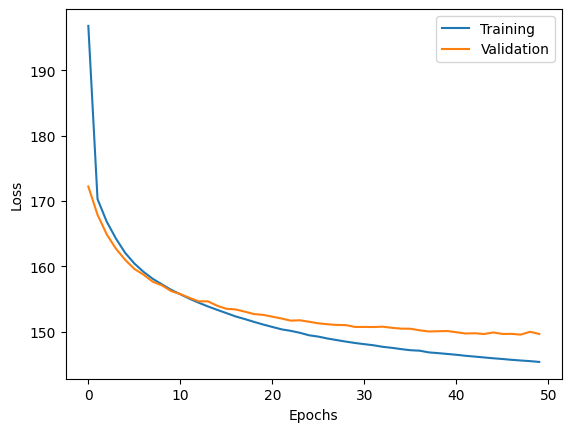

In [ ]:
plot_history(history)

Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point.

One is to look at the neighborhoods of different classes on the latent 2D plane:

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

79/79 [==============================] - 0s 2ms/step


79/79 [==============================] - 0s 2ms/step


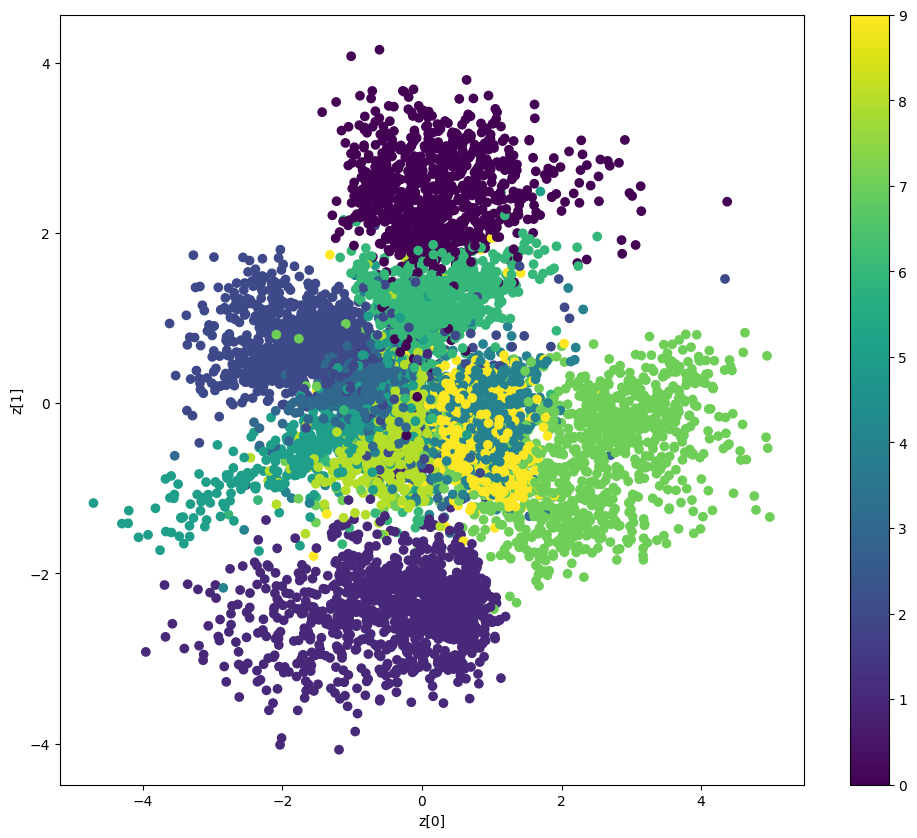

In [ ]:
# display a 2D plot of the digit classes in the latent space
z_mean, _, _ = encoder.predict(x_test,
                               batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).


Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

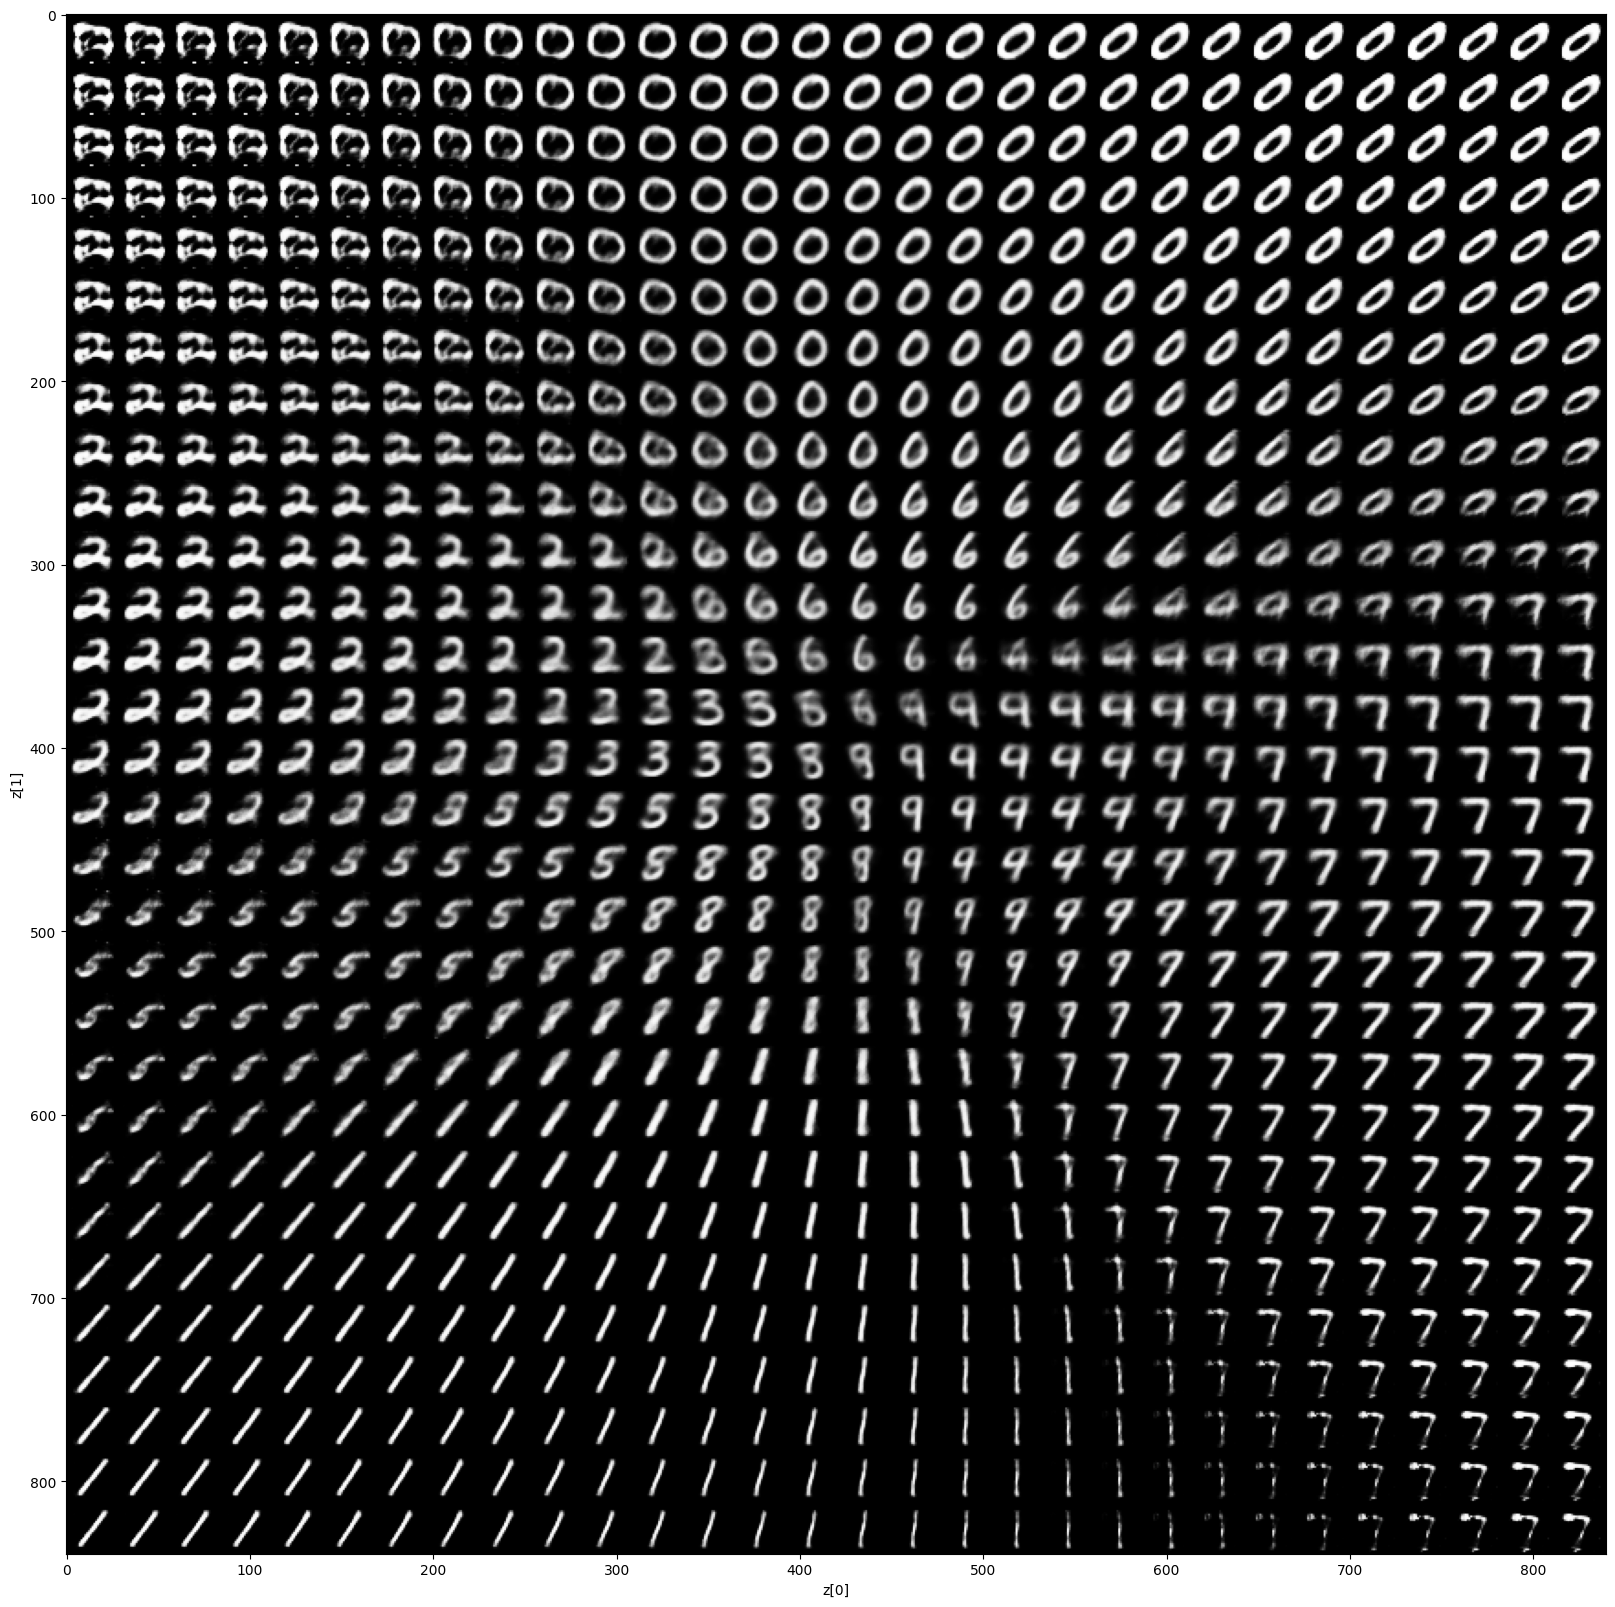

In [ ]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
#plt.xticks(pixel_range, sample_range_x)
#plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.show()